In [1]:
import sys
import os

notebook_path = os.getcwd() 
project_root = os.path.dirname(notebook_path)

if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [3]:
import NN_models
import Filters
import utils
import Systems
from torch.utils.data import TensorDataset, DataLoader, random_split
from state_NN_models.StateKalmanNet import StateKalmanNet
from state_NN_models.StateKalmanNetWithKnownR import StateKalmanNetWithKnownR

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

Používané zařízení: cuda


In [5]:
state_dim = 1
obs_dim = 1

# --- Reálný systém ("Ground Truth") ---
F_true = torch.tensor([[0.5]])
H_true = torch.tensor([[1.0]])
Q_true = torch.tensor([[0.5]])
R_true = torch.tensor([[0.1]])
Ex0_true = torch.tensor([[1.0]])  # Střední hodnota počátečního stavu
P0_true = torch.tensor([[1.5]])   # Počáteční kovariance

# --- Model systému ---
F_model = F_true
H_model = H_true
Q_model = torch.tensor([[0.1]]) 
R_model = R_true
Ex0_model = torch.tensor([[0.5]])  # Schválně jiná střední hodnota
P0_model = torch.tensor([[1.0]])   # Schválně jiná počáteční kovariance


sys_true = Systems.DynamicSystem(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Ex0=Ex0_true,
    P0=P0_true,
    Q=Q_true,
    R=R_true,
    F=F_true,
    H=H_true,
    device=device
)

sys_model = Systems.DynamicSystem(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Ex0=Ex0_model,
    P0=P0_model,
    Q=Q_model,
    R=R_model,
    F=F_model,
    H=H_model,
    device=device
)

print("\nInicializace systémů dokončena.")
print(f"Reálný systém: f(x) = {sys_true.F.item():.2f}*x, h(x) = {sys_true.H.item():.2f}*x")
print(f"Model systému: f(x) = {sys_model.F.item():.2f}*x, h(x) = {sys_model.H.item():.2f}*x")


Inicializace systémů dokončena.
Reálný systém: f(x) = 0.50*x, h(x) = 1.00*x
Model systému: f(x) = 0.50*x, h(x) = 1.00*x


In [6]:
TRAIN_SEQ_LEN = 10      # Krátké sekvence pro stabilní trénink (TBPTT)
VALID_SEQ_LEN = 20      # Stejná délka pro konzistentní validaci
TEST_SEQ_LEN = 200      # Dlouhé sekvence pro testování generalizace

NUM_TRAIN_TRAJ = 2000   # Hodně trénovacích příkladů
NUM_VALID_TRAJ = 500    # Dostatek pro spolehlivou validaci
NUM_TEST_TRAJ = 100     # Pro robustní vyhodnocení

BATCH_SIZE = 16         # Dobrý kompromis

x_train, y_train = utils.generate_data(sys_true, num_trajectories=NUM_TRAIN_TRAJ, seq_len=TRAIN_SEQ_LEN)
x_val, y_val = utils.generate_data(sys_true, num_trajectories=NUM_VALID_TRAJ, seq_len=VALID_SEQ_LEN)
x_test, y_test = utils.generate_data(sys_true, num_trajectories=1, seq_len=TEST_SEQ_LEN)

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [7]:
kalman_filter = Filters.ExtendedKalmanFilter(sys_model)
y_first_trajectory = y_test[0] 
x_true_first_trajectory = x_test[0]

kf_results = kalman_filter.process_sequence(y_first_trajectory)

x_hat_kf = kf_results['x_filtered']
P_hat_kf = kf_results['P_filtered']

print("\nZpracování dokončeno.")
print(f"Tvar odhadnutých stavů: {x_hat_kf.shape}")
print(f"Tvar skutečných stavů:  {x_true_first_trajectory.shape}")

mse_kf = torch.nn.functional.mse_loss(x_hat_kf, x_true_first_trajectory)
print(f"MSE pro EKF na první trajektorii: {mse_kf.item():.4f}")


Zpracování dokončeno.
Tvar odhadnutých stavů: torch.Size([200, 1])
Tvar skutečných stavů:  torch.Size([200, 1])
MSE pro EKF na první trajektorii: 0.1551


In [8]:
state_knet = StateKalmanNet(sys_model, device=device, hidden_size_multiplier=10).to(device)
utils.train_state_KalmanNet(
    model=state_knet, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    device=device, 
    epochs=100, 
    lr=1e-4,
    early_stopping_patience=15
)

/home/luky/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [5/100], Train Loss: 0.101988, Val Loss: 0.093151
Epoch [10/100], Train Loss: 0.092278, Val Loss: 0.088187
Epoch [15/100], Train Loss: 0.087370, Val Loss: 0.086041
Epoch [20/100], Train Loss: 0.085209, Val Loss: 0.085372
Epoch [25/100], Train Loss: 0.084519, Val Loss: 0.085236
Epoch [30/100], Train Loss: 0.084324, Val Loss: 0.085140
Epoch [35/100], Train Loss: 0.084234, Val Loss: 0.085124
Epoch [40/100], Train Loss: 0.084308, Val Loss: 0.085113
Epoch [45/100], Train Loss: 0.084183, Val Loss: 0.085087
Epoch [50/100], Train Loss: 0.084156, Val Loss: 0.085081
Epoch [55/100], Train Loss: 0.084139, Val Loss: 0.085079
Epoch [60/100], Train Loss: 0.084134, Val Loss: 0.085074
Epoch [65/100], Train Loss: 0.084124, Val Loss: 0.085073
Epoch [70/100], Train Loss: 0.084125, Val Loss: 0.085075

Early stopping spuštěno po 73 epochách.
Trénování dokončeno.
Načítám nejlepší model s validační chybou: 0.085068


StateKalmanNet(
  (dnn): DNN_KalmanNet(
    (input_layer): Linear(in_features=2, out_features=20, bias=True)
    (gru): GRU(20, 20)
    (output_layer): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [9]:
state_knet_R = StateKalmanNetWithKnownR(sys_model, device=device, hidden_size_multiplier=10).to(device)
utils.train_state_KalmanNet(
    model=state_knet_R, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    device=device, 
    epochs=100, 
    lr=1e-4,
    early_stopping_patience=15
)

Epoch [5/100], Train Loss: 0.109996, Val Loss: 0.095739, Avg Cov Trace: 0.073490
Epoch [10/100], Train Loss: 0.098804, Val Loss: 0.090774, Avg Cov Trace: 0.079524
Epoch [15/100], Train Loss: 0.092190, Val Loss: 0.087489, Avg Cov Trace: 0.080845
Epoch [20/100], Train Loss: 0.088110, Val Loss: 0.085963, Avg Cov Trace: 0.082030
Epoch [25/100], Train Loss: 0.086024, Val Loss: 0.085500, Avg Cov Trace: 0.082940
Epoch [30/100], Train Loss: 0.085118, Val Loss: 0.085417, Avg Cov Trace: 0.083366
Epoch [35/100], Train Loss: 0.084654, Val Loss: 0.085234, Avg Cov Trace: 0.083698
Epoch [40/100], Train Loss: 0.084420, Val Loss: 0.085268, Avg Cov Trace: 0.083819
Epoch [45/100], Train Loss: 0.084314, Val Loss: 0.085140, Avg Cov Trace: 0.083822
Epoch [50/100], Train Loss: 0.084256, Val Loss: 0.085142, Avg Cov Trace: 0.084064
Epoch [55/100], Train Loss: 0.084202, Val Loss: 0.085112, Avg Cov Trace: 0.083737
Epoch [60/100], Train Loss: 0.084186, Val Loss: 0.085167, Avg Cov Trace: 0.083955
Epoch [65/100], T

StateKalmanNetWithKnownR(
  (dnn): DNN_KalmanNet(
    (input_layer): Linear(in_features=2, out_features=20, bias=True)
    (gru): GRU(20, 20)
    (output_layer): Linear(in_features=20, out_features=1, bias=True)
  )
)

Generuji 100 testovacích trajektorií...
Vyhodnocuji na 100 testovacích trajektoriích...

FINÁLNÍ VÝSLEDKY (průměr přes 100 běhů)

--- Průměrná MSE (přesnost) ---
StateKalmanNet:          0.0841
StateKalmanNetWithKnownR:0.0841
EKF:                     0.1484

--- Průměrný ANEES (kredibilita/kalibrace) ---
Očekávaná hodnota: 1.0000
---------------------------------------
StateKalmanNetWithKnownR:0.9976
EKF:                     2.7903


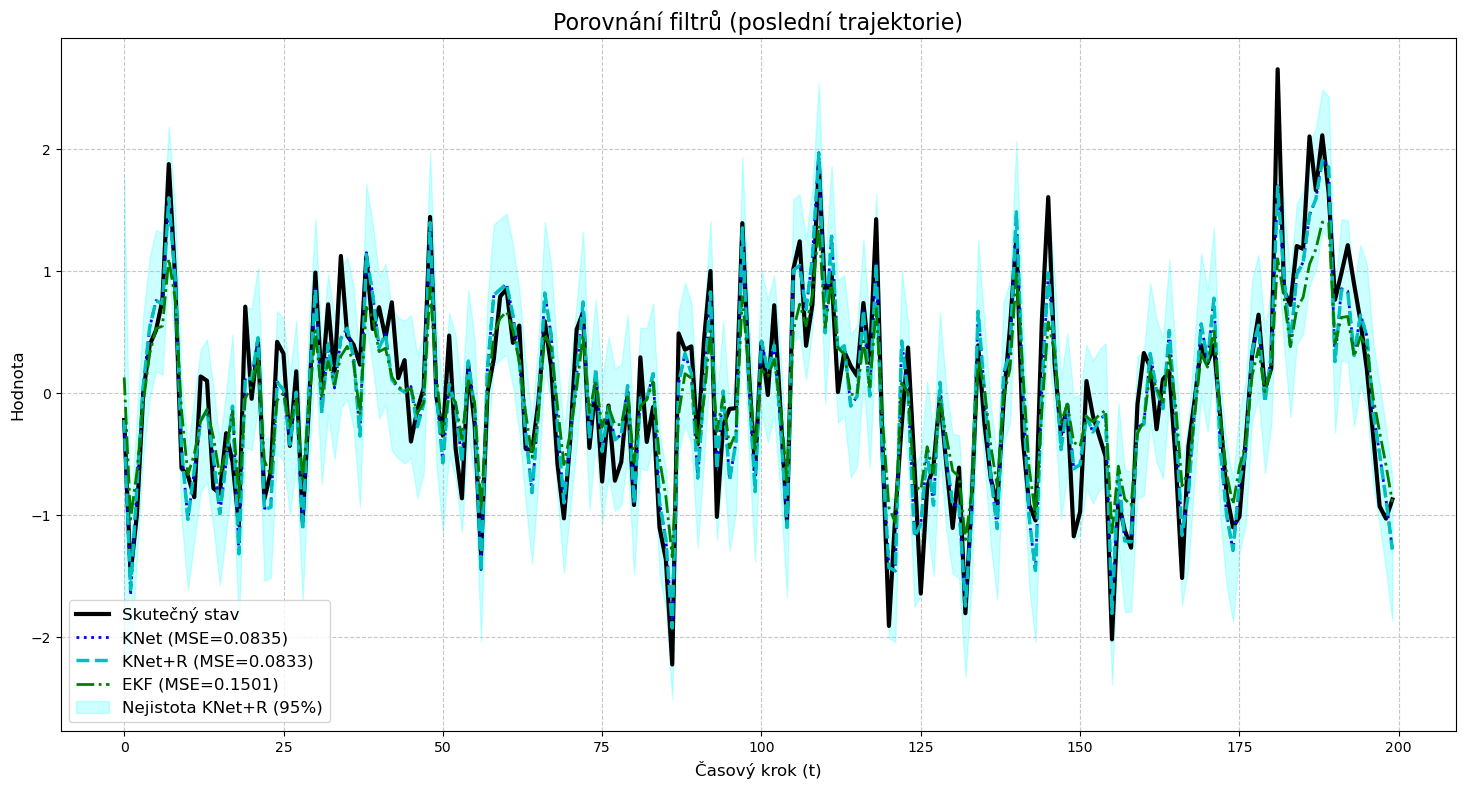

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2


def calculate_anees(x_true, x_hat, P_hat):
    """
    Vypočítá Average NEES (ANEES) pro JEDNU trajektorii.
    """
    seq_len, state_dim = x_true.shape
    nees_samples = torch.zeros(seq_len, device=x_true.device)

    for t in range(seq_len):
        error = x_true[t] - x_hat[t]
        P_t = P_hat[t]
            
        P_t_matrix = P_t.reshape(state_dim, state_dim)
        P_stable = P_t_matrix + torch.eye(state_dim, device=P_t_matrix.device) * 1e-9
        
        try:
            P_inv = torch.inverse(P_stable)
            nees_samples[t] = error.unsqueeze(0) @ P_inv @ error.unsqueeze(-1)
        except torch.linalg.LinAlgError:
            nees_samples[t] = float('nan')
            
    return torch.nanmean(nees_samples).item()

TEST_SEQ_LEN = 200
NUM_TEST_TRAJ = 100

print(f"Generuji {NUM_TEST_TRAJ} testovacích trajektorií...")
x_test, y_test = utils.generate_data(sys_true, num_trajectories=NUM_TEST_TRAJ, seq_len=TEST_SEQ_LEN)

state_knet.eval()
state_knet_R.eval()

all_mse_knet, all_mse_knet_R, all_mse_ekf = [], [], []
all_anees_knet_R, all_anees_ekf = [], []

print(f"Vyhodnocuji na {NUM_TEST_TRAJ} testovacích trajektoriích...")

with torch.no_grad():
    for i in range(NUM_TEST_TRAJ):
        y_test_seq = y_test[i].to(device)
        x_true_seq = x_test[i].to(device)
        
        initial_state_gpu = x_true_seq[0, :].unsqueeze(0)
        state_knet.reset(batch_size=1, initial_state=initial_state_gpu)
        knet_predictions_x_gpu = []
        for t in range(1, TEST_SEQ_LEN):
            y_t = y_test_seq[t, :].unsqueeze(0)
            x_filtered_t = state_knet.step(y_t)
            knet_predictions_x_gpu.append(x_filtered_t.squeeze(0))
        
        x_hat_knet_run_gpu = torch.stack(knet_predictions_x_gpu, dim=0)
        x_hat_knet_full = torch.cat([initial_state_gpu, x_hat_knet_run_gpu], dim=0).cpu()

        state_knet_R.reset(batch_size=1, initial_state=initial_state_gpu)
        knet_R_predictions_x_gpu, knet_R_predictions_P_gpu = [], []
        for t in range(1, TEST_SEQ_LEN):
            y_t = y_test_seq[t, :].unsqueeze(0)
            x_filtered_t, P_filtered_t = state_knet_R.step(y_t)
            knet_R_predictions_x_gpu.append(x_filtered_t.squeeze(0))
            knet_R_predictions_P_gpu.append(P_filtered_t.squeeze(0))
            
        x_hat_knet_R_run_gpu = torch.stack(knet_R_predictions_x_gpu, dim=0)
        P_hat_knet_R_run_gpu = torch.stack(knet_R_predictions_P_gpu, dim=0)
        
        x_hat_knet_R_full = torch.cat([initial_state_gpu, x_hat_knet_R_run_gpu], dim=0).cpu()
        P0_gpu = sys_model.P0.to(device)
        P_hat_knet_R_full = torch.cat([P0_gpu.unsqueeze(0), P_hat_knet_R_run_gpu], dim=0).cpu()
        
        ekf_instance = Filters.ExtendedKalmanFilter(sys_model)
        Ex0_run = x_true_seq[0, :].unsqueeze(-1)
        P0_run = sys_model.P0
        ekf_results = ekf_instance.process_sequence(
            y_test_seq, Ex0=Ex0_run, P0=P0_run
        )
        x_hat_ekf_full = ekf_results['x_filtered'].cpu()
        P_hat_ekf_full = ekf_results['P_filtered'].cpu()
        
        x_true_seq_cpu = x_true_seq.cpu()
        state_dim = x_true_seq_cpu.shape[1]
        
        all_mse_knet.append(F.mse_loss(x_hat_knet_full, x_true_seq_cpu).item())
        all_mse_knet_R.append(F.mse_loss(x_hat_knet_R_full, x_true_seq_cpu).item())
        all_mse_ekf.append(F.mse_loss(x_hat_ekf_full, x_true_seq_cpu).item())

        all_anees_knet_R.append(calculate_anees(x_true_seq_cpu, x_hat_knet_R_full, P_hat_knet_R_full))
        all_anees_ekf.append(calculate_anees(x_true_seq_cpu, x_hat_ekf_full, P_hat_ekf_full))

avg_mse_knet = np.mean(all_mse_knet)
avg_mse_knet_R = np.mean(all_mse_knet_R)
avg_mse_ekf = np.mean(all_mse_ekf)
avg_anees_knet_R = np.mean(all_anees_knet_R)
avg_anees_ekf = np.mean(all_anees_ekf)

print("\n" + "="*50)
print(f"FINÁLNÍ VÝSLEDKY (průměr přes {NUM_TEST_TRAJ} běhů)")
print("="*50)
print("\n--- Průměrná MSE (přesnost) ---")
print(f"StateKalmanNet:          {avg_mse_knet:.4f}")
print(f"StateKalmanNetWithKnownR:{avg_mse_knet_R:.4f}")
print(f"EKF:                     {avg_mse_ekf:.4f}")
print("\n--- Průměrný ANEES (kredibilita/kalibrace) ---")
print(f"Očekávaná hodnota: {state_dim:.4f}")
print("---------------------------------------")
print(f"StateKalmanNetWithKnownR:{avg_anees_knet_R:.4f}")
print(f"EKF:                     {avg_anees_ekf:.4f}")
print("="*50)

plt.figure(figsize=(18, 9))
plt.title("Porovnání filtrů (poslední trajektorie)", fontsize=16)

x_true_plot = x_true_seq.cpu().numpy().squeeze() 

knet_mean_plot = x_hat_knet_full.numpy().squeeze()
knet_R_mean_plot = x_hat_knet_R_full.numpy().squeeze()
ekf_mean_plot = x_hat_ekf_full.numpy().squeeze()
knet_R_std_plot = torch.sqrt(torch.diagonal(P_hat_knet_R_full, dim1=-2, dim2=-1)).numpy().squeeze()
time_steps = range(len(x_true_plot))

plt.plot(time_steps, x_true_plot, 'k-', linewidth=3, label="Skutečný stav")
plt.plot(time_steps, knet_mean_plot, 'b:', linewidth=2, label=f"KNet (MSE={all_mse_knet[-1]:.4f})")
plt.plot(time_steps, knet_R_mean_plot, 'c--', linewidth=2.5, label=f"KNet+R (MSE={all_mse_knet_R[-1]:.4f})")
plt.plot(time_steps, ekf_mean_plot, 'g-.', linewidth=2, label=f"EKF (MSE={all_mse_ekf[-1]:.4f})")
plt.fill_between(time_steps, knet_R_mean_plot - 2 * knet_R_std_plot, knet_R_mean_plot + 2 * knet_R_std_plot, 
                 color='cyan', alpha=0.2, label='Nejistota KNet+R (95%)')

plt.xlabel("Časový krok (t)", fontsize=12)
plt.ylabel("Hodnota", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()